In [1]:
import torch, h5py, time
from torch.utils.data import DataLoader, Dataset
from src.TorchDSP.core import TorchSignal, TorchInput, TorchTime
from src.TorchSimulation.receiver import BER
from src.TorchDSP.dataloader import  get_signals, opticDataset, MyDataset, get_k
import numpy as np
from src.TorchDSP.nneq import eqCNNBiLSTM, eqAMPBCaddNN
from src.TorchDSP.loss import BER_well, MSE, Qsq
from functools import partial
from torch.utils.tensorboard.writer import SummaryWriter

In [2]:
# trainset = opticDataset(Nch=3, Rs=40, M=41, Pch=[2], path='data/Nmodes2/train_batch10_4e5_afterCDCDSP.pkl', idx=[10000,-1], power_fix=False)
# train_loader = DataLoader(trainset, batch_size=5000, shuffle=True)
# testset = opticDataset(Nch=3, Rs=40, M=41, Pch=[2], path='data/Nmodes2/test_batch10_4e5_afterCDCDSP.pkl', idx=[10000,-1], power_fix=False)
# test_loader = DataLoader(testset, batch_size=5000, shuffle=False)

# net = eqAMPBCaddNN(pbc_info={'M':41, 'rho':4}, nn_info={'M':41, 'Nmodes':2, 'channels':64, 'kernel_size':11, 'hidden_size':40, 'res_net':True})
# optimizer = torch.optim.Adam(
#     [
#         {"params": net.pbc.parameters(), "lr": 0.00001},
#         {"params": net.nn.parameters(), "lr": 0.001},
#     ]
# )

data = MyDataset(path='dataset/train.h5', Nch=3, Rs=40, Pch=2, window_size=41, transform='Rx_CDCDSP_PBC', Nsymb=4000000)
train_loader = DataLoader(data, batch_size=5000, shuffle=True, num_workers=16)
testdata = MyDataset(path='dataset/test.h5', Nch=3, Rs=40, Pch=2, window_size=41, transform='Rx_CDCDSP_PBC', Nsymb=200000)
test_loader = DataLoader(testdata, batch_size=50000, shuffle=False, num_workers=16)

net = eqCNNBiLSTM(M=41, Nmodes=2, channels=32, kernel_size=11, hidden_size=40, res_net=True)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=1)

epochs = 60
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# loss_fn = BER_well
# mus =  4*1.1**np.repeat(np.arange(0, epochs//2 + 1), 2)


def test_model(dataloader, model, loss_fn, device):
    model = model.to(device)
    model.eval()
    mse = 0 
    ber = 0
    power = 0

    N = len(dataloader)
    with torch.no_grad():
        for x, y, z in dataloader:
            x, y, z = x.to(device), y.to(device), z.to(device)
            y_pred = model(x)
            mse += loss_fn(y_pred, y).item()
            power += MSE(0, y).item()
            ber += BER(y, y_pred)['BER']
            
    return {'loss_fn': mse/N, 'BER': np.mean(ber/N), 'SNR': 10 * np.log10(power / mse), 'Qsq': Qsq(np.mean(ber/N)), 'BER_XY':ber/N, 'Qsq_XY': Qsq(ber/N)}

def train_model(log_path,train_loader, test_loader, net, loss_fn, optimizer, device, epoch0=0, epochs=10, mus=[0]):
    writer = SummaryWriter(log_path)
    net = net.to(device)
    metrics = []
    metrics.append(test_model(test_loader, net, loss_fn, device))

    for epoch in range(epochs + 1):
        net.train()
        train_loss = 0
        N = len(train_loader)

        loss_func = partial(loss_fn, mu=mus[epoch])
        t0 = time.time()
        for x,y,z in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            predict = net(x)
            loss = loss_func(predict, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            print(loss.item(), end='\r', flush=True)
        t1 = time.time()
        scheduler.step()

        print('Epoch: %d, Loss: %.5f, time: %.5f' % (epoch, train_loss/N, t1-t0), flush=True)
        if epoch % 2 == 0:
            metric = test_model(test_loader, net, loss_fn=MSE, device=device)
            print(metric, flush=True)
            metrics.append(metric)

            writer.add_scalar('Loss/train', train_loss/N, epoch)
            writer.add_scalar('Loss/test', metric['loss_fn'], epoch)
            writer.add_scalar('Metric/Qsq', metric['Qsq'], epoch)
            writer.add_scalar('Metric/SNR', metric['SNR'], epoch)
            writer.add_scalar('Metric/BER', metric['BER'], epoch)
            writer.add_scalar('Metric/Qsq_X', metric['Qsq_XY'][0], epoch)
            writer.add_scalar('Metric/Qsq_Y', metric['Qsq_XY'][1], epoch)
    
    writer.close()
    return metrics

In [3]:
epochs = 60
loss_fn = BER_well
mus =  4*1.1**np.repeat(np.arange(0, epochs//2 + 1), 2)

# loss_fn = MSE
# mus =  np.zeros(epochs+1)

metrics =  train_model('_outputs/log_tensorboard/notebook/BER_D400w', train_loader, test_loader, net, loss_fn, optimizer, device, epochs, mus)

Epoch: 0, Loss: 0.47925, time: 21.51678
{'loss_fn': 0.03329603001475334, 'BER': 0.0066175, 'SNR': 14.772051884348363, 'Qsq': 7.879861114586029, 'BER_XY': array([0.006555, 0.00668 ], dtype=float32), 'Qsq_XY': array([7.89172  , 7.8680854], dtype=float32)}
Epoch: 1, Loss: 0.47913, time: 23.80037
Epoch: 2, Loss: 0.44508, time: 21.47320
{'loss_fn': 0.03317155409604311, 'BER': 0.0065549994, 'SNR': 14.788318239909932, 'Qsq': 7.891719998701698, 'BER_XY': array([0.0064925, 0.0066175], dtype=float32), 'Qsq_XY': array([7.9036627, 7.879861 ], dtype=float32)}
Epoch: 3, Loss: 0.44479, time: 23.43181
Epoch: 4, Loss: 0.41061, time: 23.06355
{'loss_fn': 0.03282855823636055, 'BER': 0.006275625, 'SNR': 14.833458329818566, 'Qsq': 7.945777370983619, 'BER_XY': array([0.00621875, 0.0063325 ], dtype=float32), 'Qsq_XY': array([7.957001 , 7.9346294], dtype=float32)}
Epoch: 5, Loss: 0.41002, time: 22.24108
Epoch: 6, Loss: 0.36819, time: 22.13466
{'loss_fn': 0.024360837414860725, 'BER': 0.0060137496, 'SNR': 16.12

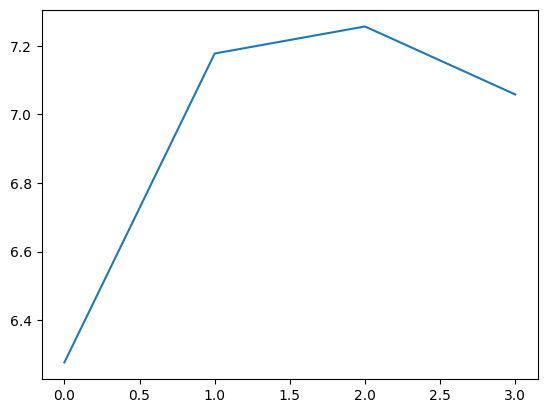

In [16]:
import matplotlib.pyplot as plt
plt.plot([m['Qsq'] for m in metrics])

In [11]:
epochs = 60
loss_fn = BER_well
mus =  4*1.1**np.repeat(np.arange(0, epochs//2 + 1), 2)

# loss_fn = MSE
# mus =  np.zeros(epochs+1)

metrics1 =  train_model(train_loader, test_loader, net, loss_fn, optimizer, device, epochs, mus)

In [16]:
x1 = net(y.to(device))

tensor([[ 0.4384-0.3250j, -0.2996+0.9574j],
        [ 0.3397+0.3107j,  0.3402-0.9531j],
        [ 0.3048+0.9356j,  0.9374-0.5241j],
        ...,
        [-0.3163-0.9649j, -0.3009+0.4159j],
        [ 0.3023-0.9608j, -0.3186+0.9395j],
        [-0.7674-0.9583j, -0.9233+0.9567j]])

In [21]:
BER(x1.cpu().detach(),x)

{'BER': array([0.005035, 0.00565 ], dtype=float32),
 'SER': array([0.02   , 0.02246], dtype=float32),
 'Qsq': array([8.210201, 8.073671], dtype=float32),
 'SNR': array([21.832146, 18.59746 ], dtype=float32)}

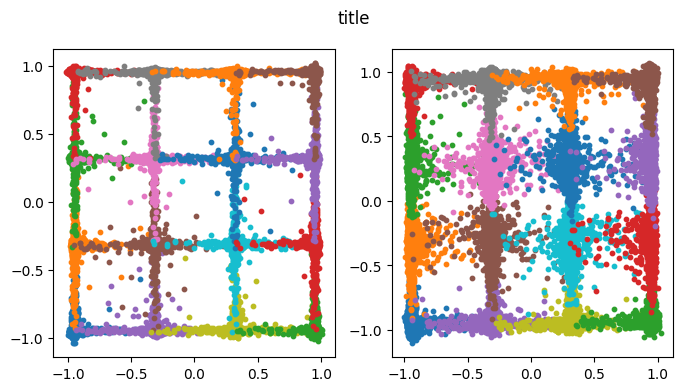

In [25]:
from src.TorchSimulation.utils import show_symb

show_symb(x1.cpu().detach().numpy(), x.numpy())